In [2]:
import numpy as np
import pandas as pd
import os
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import collections
import lightgbm
from lightgbm import *

pd.set_option("display.max_column", 999)
#print(os.listdir("../input"))

# Loading and preparing the data

In [3]:
tourney_results = pd.read_csv('NCAATourneyDetailedResults.csv')
seeds = pd.read_csv('NCAATourneySeeds.csv')
regular_results = pd.read_csv('RegularSeasonDetailedResults.csv')

In [4]:
def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    return output

In [5]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

In [6]:
regular_data.shape

(175008, 35)

In [7]:
tourney_data.shape

(2096, 35)

In [8]:
regular_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,10,1104,68,1328,62,0,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,6
1,2003,10,1272,70,1393,63,0,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,7
2,2003,11,1266,73,1437,61,0,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,12
3,2003,11,1296,56,1457,50,0,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,6
4,2003,11,1400,77,1208,71,0,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14,6


In [9]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,134,1421,92,1411,84,0,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22,8
1,2003,136,1112,80,1436,51,0,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15,29
2,2003,136,1113,84,1272,71,0,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18,13
3,2003,136,1141,79,1166,73,0,0,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21,6
4,2003,136,1143,76,1301,74,0,1,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19,2


# Feature engineering

In [10]:
boxscore_cols = ['T1_Score', 'T2_Score', 
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF', 
        'PointDiff']

boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff']

In [11]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg([np.mean])
season_statistics.head()

T1_FGM     T1_FGA   T1_FGM3    T1_FGA3      T1_OR  \
                       mean       mean      mean       mean       mean   
Season T1_TeamID                                                         
2003   1102       19.142857  39.785714  7.821429  20.821429   4.178571   
       1103       27.148148  55.851852  5.444444  16.074074   9.777778   
       1104       24.035714  57.178571  6.357143  19.857143  13.571429   
       1105       24.384615  61.615385  7.576923  20.769231  13.500000   
       1106       23.428571  55.285714  6.107143  17.642857  12.285714   

                     T1_Ast      T1_TO    T1_Stl      T1_PF     T2_FGM  \
                       mean       mean      mean       mean       mean   
Season T1_TeamID                                                         
2003   1102       13.000000  11.428571  5.964286  18.750000  19.285714   
       1103       15.222222  12.629630  7.259259  19.851852  27.777778   
       1104       12.107143  13.285714  6.607143  18.035714  23.250000   
       1105       14.538462  18.653846  9.307692  20.230769  27.000000   
       1106       11.678571  17.035714  8.357143  18.178571  21.714286   

                     T2_FGA   T2_FGM3    T2_FGA3      T2_OR     T2_Ast  \
                       mean      mean       mean       mean       mean   
Season T1_TeamID                                                         
2003   1102       42.428571  4.750000  12.428571   9.607143   9.142857   
       1103       57.000000  6.666667  18.370370  12.037037  15.481481   
       1104       55.500000  6.357143  19.142857  10.892857  11.678571   
       1105       58.961538  6.269231  17.538462  13.192308  15.807692   
       1106       53.392857  4.785714  15.214286  11.321429  11.785714   

                      T2_TO    T2_Stl    T2_Blk PointDiff  
                       mean      mean      mean      mean  
Season T1_TeamID                                           
2003   1102       12.964286  5.428571  1.571429  0.250000  
       1103       15.333333  6.407407  2.851852  0.629630  
       1104       13.857143  5.535714  3.178571  4.285714  
       1105       18.807692  9.384615  4.192308 -4.884615  
       1106       15.071429  8.785714  3.178571 -0.142857

In [12]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg([np.mean]).reset_index()
season_statistics.head()

,Season,T1_TeamID,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_OR,T1_Ast,T1_TO,T1_Stl,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_OR,T2_Ast,T2_TO,T2_Stl,T2_Blk,PointDiff
,,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [13]:
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
season_statistics.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [14]:
season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

In [15]:
season_statistics_T1.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [16]:
season_statistics_T2.head()

,Season,T2_TeamID,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [17]:
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score
0,2003,134,1421,92,1411,84
1,2003,136,1112,80,1436,51
2,2003,136,1113,84,1272,71
3,2003,136,1141,79,1166,73
4,2003,136,1143,76,1301,74


In [18]:
tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [19]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,12.275862,13.034483,16.206897,7.068966,19.103448,27.793103,60.965517,7.620690,20.758621,13.724138,15.862069,12.827586,8.827586,4.241379,-7.241379,24.733333,55.266667,5.933333,18.500000,13.166667,14.200000,15.233333,6.433333,18.300000,25.666667,60.400000,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,15.178571,17.642857,14.785714,8.464286,17.750000,26.357143,64.678571,6.321429,19.964286,13.107143,15.464286,16.857143,5.964286,2.392857,14.964286,24.827586,55.862069,5.275862,15.482759,12.965517,14.206897,14.068966,6.862069,15.896552,22.758621,55.068966,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,13.689655,15.551724,14.000000,5.206897,19.413793,24.793103,55.655172,5.448276,15.896552,11.000000,14.068966,15.517241,6.000000,3.931034,6.793103,26.275862,60.000000,7.000000,20.068966,14.068966,16.620690,13.793103,7.379310,18.758621,23.275862,57.862069,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,10.586207,15.620690,18.241379,7.103448,20.965517,26.344828,57.931034,4.965517,13.896552,12.241379,11.793103,16.068966,8.448276,2.482759,6.103448,28.696970,57.454545,7.969697,20.484848,10.878788,16.818182,13.363636,8.393939,17.272727,23.878788,55.333333,4.878788,14.303030,11.060606,12.363636,17.060606,6.333333,2.575758,14.909091
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,11.241379,16.000000,14.172414,6.551724,17.103448,25.379310,58.793103,7.103448,21.448276,11.172414,16.034483,14.931034,5.931034,2.517241,4.724138,24.333333,53.333333,7.966667,22.500000,9.733333,14.666667,14.200000,7.766667,18.666667,23.433333,53.133333,5.733333,17.000000,10.533333,12.566667,14.633333,7.433333,2.833333,4.400000


# Added winrate for last 2 weeks

In [20]:
last14days_stats_T1 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

last14days_stats_T2 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

In [21]:
tourney_data = pd.merge(tourney_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [22]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,12.275862,13.034483,16.206897,7.068966,19.103448,27.793103,60.965517,7.620690,20.758621,13.724138,15.862069,12.827586,8.827586,4.241379,-7.241379,24.733333,55.266667,5.933333,18.500000,13.166667,14.200000,15.233333,6.433333,18.300000,25.666667,60.400000,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667,1.000000,0.833333
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,15.178571,17.642857,14.785714,8.464286,17.750000,26.357143,64.678571,6.321429,19.964286,13.107143,15.464286,16.857143,5.964286,2.392857,14.964286,24.827586,55.862069,5.275862,15.482759,12.965517,14.206897,14.068966,6.862069,15.896552,22.758621,55.068966,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172,0.666667,1.000000
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,13.689655,15.551724,14.000000,5.206897,19.413793,24.793103,55.655172,5.448276,15.896552,11.000000,14.068966,15.517241,6.000000,3.931034,6.793103,26.275862,60.000000,7.000000,20.068966,14.068966,16.620690,13.793103,7.379310,18.758621,23.275862,57.862069,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655,0.666667,0.750000
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,10.586207,15.620690,18.241379,7.103448,20.965517,26.344828,57.931034,4.965517,13.896552,12.241379,11.793103,16.068966,8.448276,2.482759,6.103448,28.696970,57.454545,7.969697,20.484848,10.878788,16.818182,13.363636,8.393939,17.272727,23.878788,55.333333,4.878788,14.303030,11.060606,12.363636,17.060606,6.333333,2.575758,14.909091,1.000000,1.000000
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,11.241379,16.000000,14.172414,6.551724,17.103448,25.379310,58.793103,7.103448,21.448276,11.172414,16.034483,14.931034,5.931034,2.517241,4.724138,24.333333,53.333333,7.966667,22.500000,9.733333,14.666667,14.200000,7.766667,18.666667,23.433333,53.133333,5.733333,17.000000,10.533333,12.566667,14.633333,7.433333,2.833333,4.400000,0.333333,0.600000


# Only playoffs teams in regular_season_effects

In [23]:
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.head()

,Season,T1_TeamID,T2_TeamID,PointDiff,win
0,2003,1104,1328,6,1
1,2003,1272,1393,7,1
2,2003,1323,1237,44,1
3,2003,1242,1221,24,1
4,2003,1390,1462,1,1


In [24]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds.head()

,Season,Seed,TeamID,seed
0,1985,W01,1207,1
1,1985,W02,1210,2
2,1985,W03,1228,3
3,1985,W04,1260,4
4,1985,W05,1374,5


In [25]:
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']
tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,12.275862,13.034483,16.206897,7.068966,19.103448,27.793103,60.965517,7.620690,20.758621,13.724138,15.862069,12.827586,8.827586,4.241379,-7.241379,24.733333,55.266667,5.933333,18.500000,13.166667,14.200000,15.233333,6.433333,18.300000,25.666667,60.400000,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667,1.000000,0.833333,16,16,0
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,15.178571,17.642857,14.785714,8.464286,17.750000,26.357143,64.678571,6.321429,19.964286,13.107143,15.464286,16.857143,5.964286,2.392857,14.964286,24.827586,55.862069,5.275862,15.482759,12.965517,14.206897,14.068966,6.862069,15.896552,22.758621,55.068966,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172,0.666667,1.000000,1,16,-15
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,13.689655,15.551724,14.000000,5.206897,19.413793,24.793103,55.655172,5.448276,15.896552,11.000000,14.068966,15.517241,6.000000,3.931034,6.793103,26.275862,60.000000,7.000000,20.068966,14.068966,16.620690,13.793103,7.379310,18.758621,23.275862,57.862069,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655,0.666667,0.750000,10,7,3
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,10.586207,15.620690,18.241379,7.103448,20.965517,26.344828,57.931034,4.965517,13.896552,12.241379,11.793103,16.068966,8.448276,2.482759,6.103448,28.696970,57.454545,7.969697,20.484848,10.878788,16.818182,13.363636,8.393939,17.272727,23.878788,55.333333,4.878788,14.303030,11.060606,12.363636,17.060606,6.333333,2.575758,14.909091,1.000000,1.000000,11,6,5
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,11.241379,16.000000,14.172414,6.551724,17.103448,25.379310,58.793103,7.103448,21.448276,11.172414,16.034483,14.931034,5.931034,2.517241,4.724138,24.333333,53.333333,7.966667,22.500000,9.733333,14.666667,14.200000,7.766667,18.666667,23.433333,53.133333,5.733333,17.000000,10.533333,12.566667,14.633333,7.433333,2.833333,4.400000,0.333333,0.600000,8,9,-1


In [26]:
tourney_data.shape

(2096, 49)

In [27]:
y = tourney_data['T1_Score'] - tourney_data['T2_Score']

In [29]:
features = list(season_statistics_T1.columns[2:]) + \
    list(season_statistics_T2.columns[2:]) + \
    list(seeds_T1.columns[2:]) + \
    list(seeds_T2.columns[2:]) + \
    list(last14days_stats_T1.columns[2:]) + \
    list(last14days_stats_T2.columns[2:]) + \
    ["Seed_diff"] 

# Remove duplicate features

In [33]:
features.remove('T1_opponent_ORmean')
features.remove('T2_opponent_ORmean')
features.remove('T1_opponent_FGM3mean')
features.remove('T2_opponent_FGM3mean')
features.remove('T1_opponent_Blkmean')
features.remove('T2_opponent_Blkmean')
features.remove('T1_Astmean')
features.remove('T2_Astmean')
features.remove('T1_opponent_FGAmean')
features.remove('T2_opponent_FGAmean')
features.remove('T1_FGA3mean')
features.remove('T2_FGA3mean')
features.remove('T1_FGAmean') 
features.remove('T2_FGAmean')
features.remove('T1_FGM3mean')
features.remove('T2_FGM3mean')

In [34]:
len(features)

27

#  Kenpom

In [35]:
TS = pd.read_csv('TeamSpellings1.csv', encoding = "ISO-8859-1")

In [36]:
kp = pd.read_excel('kenpom-2019.xlsx')
kp['Team'] = kp['Team'].str.replace('\d+', '')
kp['Team'] = kp['Team'].map(lambda x: str(x)[:-1])
kp['Team'] = kp['Team'].str.lower()
kp['Team'] = kp['Team'].map(TS.set_index('TeamNameSpelling')['TeamID'])
kp = kp.fillna(0)
kp.Team = kp.Team.astype(int)
kp = kp.reindex(kp.Team.abs().sort_values().index)
kp = kp[kp['Team'] > 0]
kp.AdjEM = kp.AdjEM.astype(str)
kp['AdjEM'] = kp['AdjEM'].map(lambda x: x.lstrip('+'))
kp['Season'] = 2019
kp.AdjEM = pd.to_numeric(kp.AdjEM)

In [37]:
ksub = pd.read_csv('SampleSubmissionStage2.csv')
ksub["Season"] = ksub["ID"].apply(lambda x: x[0:4]).astype(int)
ksub["T1_TeamID"] = ksub["ID"].apply(lambda x: x[5:9]).astype(int)
ksub["T2_TeamID"] = ksub["ID"].apply(lambda x: x[10:14]).astype(int)
ksub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID
0,2019_1101_1113,0.5,2019,1101,1113
1,2019_1101_1120,0.5,2019,1101,1120
2,2019_1101_1124,0.5,2019,1101,1124
3,2019_1101_1125,0.5,2019,1101,1125
4,2019_1101_1133,0.5,2019,1101,1133


In [38]:
ksubnew = ksub.melt(['ID', 'Pred', 'Season'], value_name='Team', var_name='type')
ksubnew = pd.merge(ksubnew, kp, how = 'left', left_on = ['Team', 'Season'],right_on = ['Team', 'Season'])

In [39]:
ks1 = ksubnew.iloc[0:2278]
ks2 = ksubnew.iloc[2278:]
fksubnew = pd.merge(ks1,ks2, how='left', left_on='ID', right_on='ID')
fksubnew.head()

,ID,Pred_x,Season_x,type_x,Team_x,Conf_x,AdjEM_x,AdjO_x,AdjD_x,AdjT_x,OppO_x,OppD_x,Pred_y,Season_y,type_y,Team_y,Conf_y,AdjEM_y,AdjO_y,AdjD_y,AdjT_y,OppO_y,OppD_y
0,2019_1101_1113,0.5,2019,T1_TeamID,1101,Slnd,2.07,103.7,101.6,65.9,99.7,108.7,0.5,2019,T2_TeamID,1113,P12,11.22,109.9,98.6,70.4,106.7,101.9
1,2019_1101_1120,0.5,2019,T1_TeamID,1101,Slnd,2.07,103.7,101.6,65.9,99.7,108.7,0.5,2019,T2_TeamID,1120,SEC,23.39,119.7,96.3,67.4,109.7,98.8
2,2019_1101_1124,0.5,2019,T1_TeamID,1101,Slnd,2.07,103.7,101.6,65.9,99.7,108.7,0.5,2019,T2_TeamID,1124,B12,15.24,113.6,98.3,65.2,107.9,98.8
3,2019_1101_1125,0.5,2019,T1_TeamID,1101,Slnd,2.07,103.7,101.6,65.9,99.7,108.7,0.5,2019,T2_TeamID,1125,OVC,13.69,115,101.3,71,103.1,105.7
4,2019_1101_1133,0.5,2019,T1_TeamID,1101,Slnd,2.07,103.7,101.6,65.9,99.7,108.7,0.5,2019,T2_TeamID,1133,MVC,-0.32,101,101.4,65,102.1,104.2


In [40]:
fksubnew['Pred1'] = (fksubnew['AdjEM_x'] - fksubnew['AdjEM_y']) * (fksubnew['AdjT_x'] + fksubnew['AdjT_y']) / 200

In [41]:
X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)

C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


## Defining loss

In [42]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

In [43]:
param = {} 
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.02 
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 10 
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3
param['silent'] = 1

In [44]:
xgb_cv = []
repeat_cv = 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Fold repeater 0
[0]	train-mae:11.3356+0.122671	test-mae:11.339+0.501027
[50]	train-mae:9.19992+0.0726679	test-mae:9.36688+0.435898
[100]	train-mae:8.63812+0.056346	test-mae:8.93978+0.329908
[150]	train-mae:8.40134+0.0507407	test-mae:8.82518+0.276697
[200]	train-mae:8.24387+0.0512644	test-mae:8.79441+0.248747
[250]	train-mae:8.11976+0.0519568	test-mae:8.78496+0.235829
[300]	train-mae:8.00884+0.0499359	test-mae:8.78458+0.222793
Fold repeater 1
[0]	train-mae:11.3337+0.0429256	test-mae:11.337+0.176364
[50]	train-mae:9.20097+0.0548775	test-mae:9.35561+0.262617
[100]	train-mae:8.63827+0.0557469	test-mae:8.94447+0.246464
[150]	train-mae:8.40042+0.0550431	test-mae:8.84346+0.220541
[200]	train-mae:8.24435+0.0527899	test-mae:8.82197+0.203422
[250]	train-mae:8.11994+0.0513218	test-mae:8.81871+0.195298
Fold repeater 2
[0]	train-mae:11.3345+0.0600912	test-mae:11.3374+0.250296
[50]	train-mae:9.2056+0.0512607	test-mae:9.35736+0.210617
[100]	train-mae:8.64213+0.0557798	test-mae:8.94297+0.231033
[150]	

In [46]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([285, 238, 260, 259, 269, 213, 217, 216, 238, 222],
 [8.781963399999999,
  8.818042,
  8.7942452,
  8.8044706,
  8.788057600000002,
  8.8329376,
  8.792828199999999,
  8.802399600000001,
  8.8097454,
  8.8076066])

In [47]:
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0


C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4
Fold repeater 5
Fold repeater 6
Fold repeater 7
Fold repeater 8
Fold repeater 9


### xgB probability/Final difference

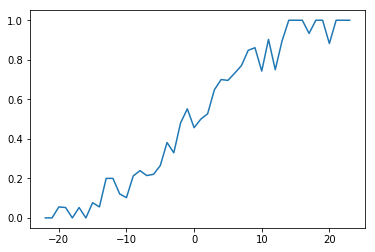

In [48]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

In [49]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.5476423922671613
logloss of cvsplit 1: 0.547487427727642
logloss of cvsplit 2: 0.5469231612306478
logloss of cvsplit 3: 0.5480501647816388
logloss of cvsplit 4: 0.5457207520007904
logloss of cvsplit 5: 0.5494583184927683
logloss of cvsplit 6: 0.545575396868359
logloss of cvsplit 7: 0.5463761753505333
logloss of cvsplit 8: 0.5473233532354744
logloss of cvsplit 9: 0.5470738422958632


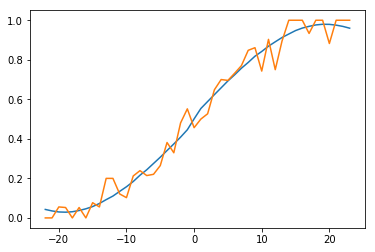

In [50]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')['spline','label'].mean().reset_index()

plt.figure()
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

In [51]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5475662714252736
adjusted logloss of cvsplit 1: 0.547487427727642
adjusted logloss of cvsplit 2: 0.5468362547096756
adjusted logloss of cvsplit 3: 0.5480488354074244
adjusted logloss of cvsplit 4: 0.5456598927608439
adjusted logloss of cvsplit 5: 0.5493628256682382
adjusted logloss of cvsplit 6: 0.5455742743003268
adjusted logloss of cvsplit 7: 0.5463344913256103
adjusted logloss of cvsplit 8: 0.5473233532354744
adjusted logloss of cvsplit 9: 0.5470738422958632


In [52]:
pd.to_numeric(fksubnew['Pred1']).head()

0    -6.235725
1   -14.209780
2    -8.632935
3    -7.953890
4     1.564255
Name: Pred1, dtype: float64

# Clipping probs and submitting

In [53]:
sub_preds_n = []
for i in range(8):
    sub_preds_n.append(np.clip(spline_model[i](np.clip(pd.to_numeric(fksubnew['Pred1']),-30,30)),0.025,0.975))
    
newspline = pd.DataFrame(sub_preds_n).mean(axis=0)

In [54]:
fksubnew['Pred'] = newspline
fksubnew[['ID','Pred']].to_csv("kenpom-submission.csv", index = None)